In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Setting to make numbers easier to read on display
pd.options.display.float_format = '{:20.2f}'.format

# Show all columns on output
pd.set_option('display.max_columns', 999)

## Data Exploration

In [ ]:
all_sheets = pd.read_excel("online_retail_II.xlsx", sheet_name=None)

# 2. Concatenate the values (the dataframes) from the dictionary into one df
df = pd.concat(all_sheets.values(), ignore_index=True)


In [9]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [11]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


In [12]:
df.describe(include=['O'])

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [13]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [14]:
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

array([nan, 'C', 'A'], dtype=object)

In [15]:
df["StockCode"]= df["StockCode"].astype("str")

df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

## Data Cleaning

In [16]:
cleaned_df = df.copy()

In [17]:
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")
mask = (
    cleaned_df["Invoice"].str.match("^\\d{6}$") == True 
)
cleaned_df = cleaned_df[mask]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [18]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")
mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True) | 
    (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
)
cleaned_df = cleaned_df[mask]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [19]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

C:\Users\nafay\AppData\Local\Temp\ipykernel_7240\1633333693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.dropna(subset=["Customer ID"], inplace=True)


In [20]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406323.00,406323,406323.00,406323.00
mean,13.62,2010-07-01 10:14:46.649094656,2.99,15373.66
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14004.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.37


In [21]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0]

In [22]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406295.00,406295,406295.00,406295.00
mean,13.62,2010-07-01 10:18:05.997415424,2.99,15373.75
min,1.00,2009-12-01 07:45:00,0.03,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14006.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.33


In [23]:
(len(cleaned_df)/len(df))*100

77.32162805612596

In Cleaning Process Dropped about 25% of data. Remaining is 75%

## Feature Engineering

In [24]:
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]

cleaned_df

C:\Users\nafay\AppData\Local\Temp\ipykernel_7240\2846558921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50


In [25]:
aggregated_df = cleaned_df.groupby(by= "Customer ID", as_index= False)\
    .agg(
        MonetaryValue = ("SalesLineTotal", "sum"),
        Frequency = ("Invoice", "nunique"),
        LastInvoiceDate = ("InvoiceDate", "max")
    ) 
aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.00,169.36,2,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,221.16,1,2010-09-27 14:59:00
3,12349.00,2221.14,2,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00


In [26]:
max_invoice_date = cleaned_df["InvoiceDate"].max()
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days
aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.00,169.36,2,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73
3,12349.00,2221.14,2,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10


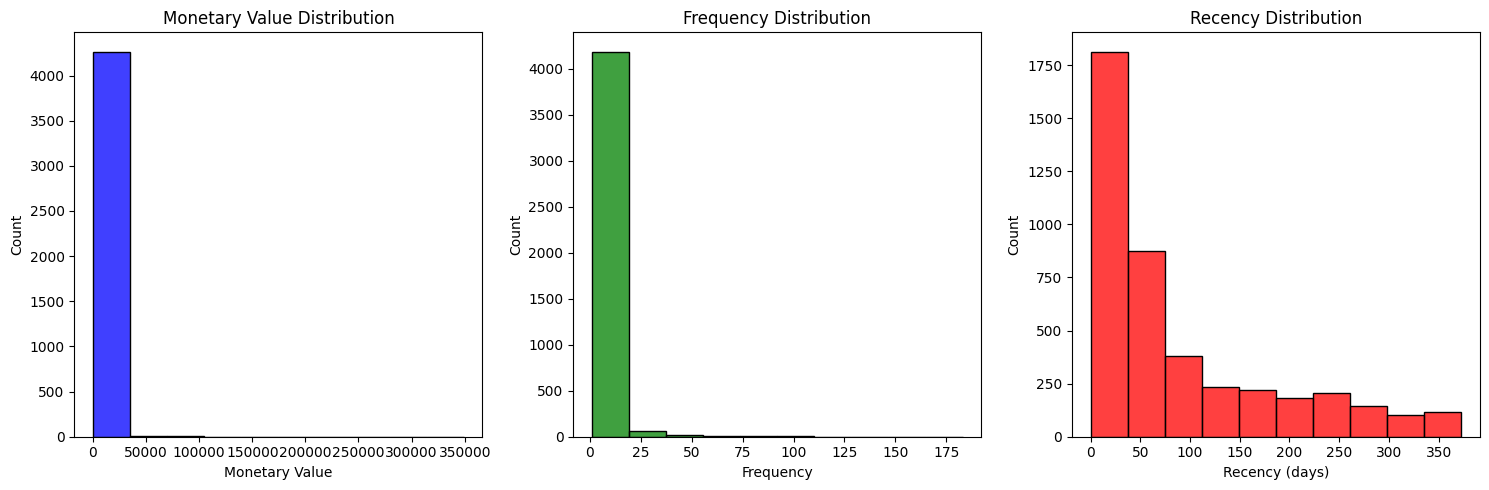

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(aggregated_df["MonetaryValue"], bins=10, color='blue', edgecolor='black')
plt.title("Monetary Value Distribution")
plt.xlabel("Monetary Value")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.histplot(aggregated_df["Frequency"], bins=10, color='green', edgecolor='black')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
sns.histplot(aggregated_df["Recency"], bins=10, color='red', edgecolor='black')
plt.title("Recency Distribution")
plt.xlabel("Recency (days)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


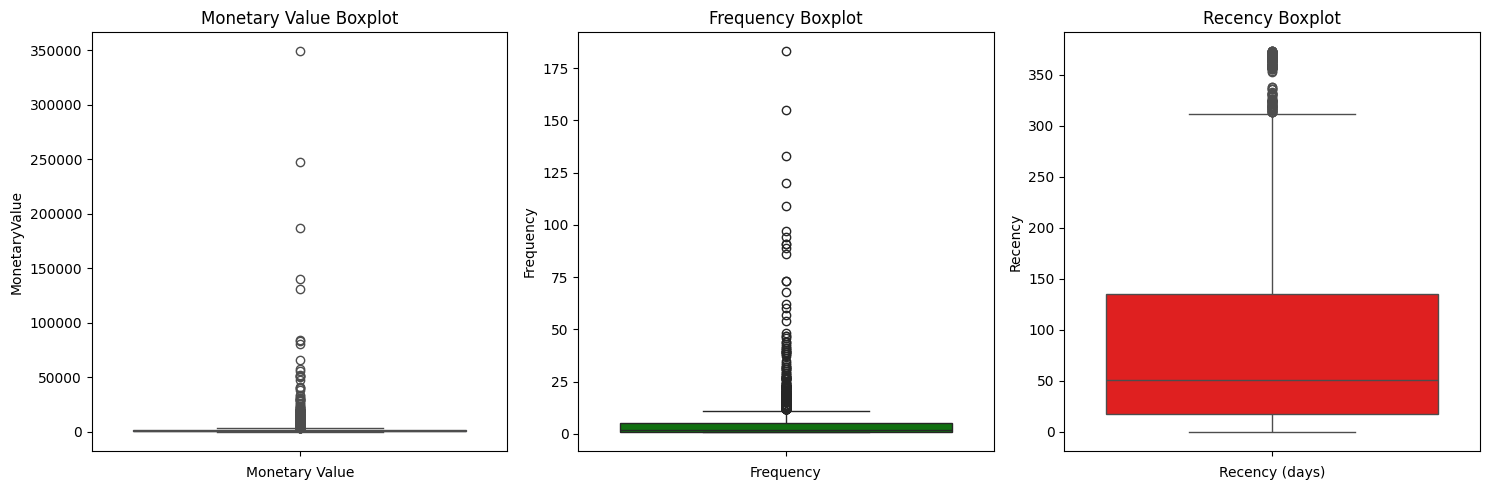

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df["MonetaryValue"], color='blue')
plt.title("Monetary Value Boxplot")
plt.xlabel("Monetary Value")

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df["Frequency"], color='green')
plt.title("Frequency Boxplot")
plt.xlabel("Frequency")

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df["Recency"], color='red')
plt.title("Recency Boxplot")
plt.xlabel("Recency (days)")

plt.tight_layout()
plt.show()

In [29]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] < M_Q1 - 1.5 * M_IQR) | (aggregated_df["MonetaryValue"] > M_Q3 + 1.5 * M_IQR)].copy()

monetary_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [30]:
F_Q1 = aggregated_df["Frequency"].quantile(0.25)
F_Q3 = aggregated_df["Frequency"].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[(aggregated_df["Frequency"] < F_Q1 - 1.5 * F_IQR) | (aggregated_df["Frequency"] > F_Q3 + 1.5 * F_IQR)].copy()

frequency_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [31]:
non_outliers_df = aggregated_df[~aggregated_df.index.isin(monetary_outliers_df.index) & ~aggregated_df.index.isin(frequency_outliers_df.index)].copy()

non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


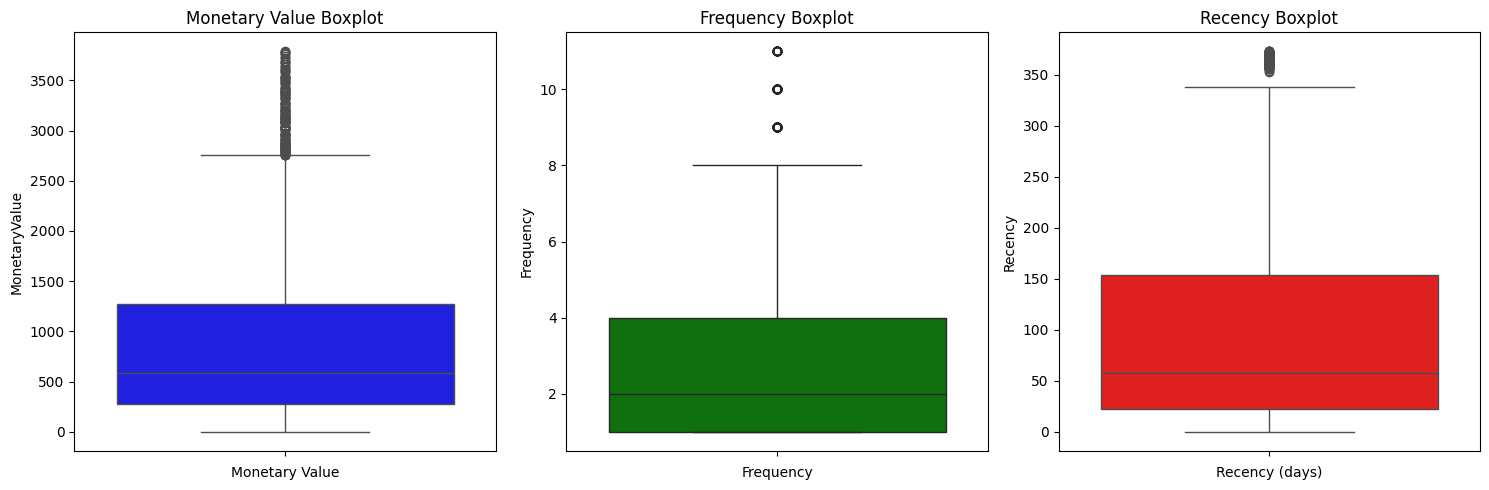

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df["MonetaryValue"], color='blue')
plt.title("Monetary Value Boxplot")
plt.xlabel("Monetary Value")

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df["Frequency"], color='green')
plt.title("Frequency Boxplot")
plt.xlabel("Frequency")

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df["Recency"], color='red')
plt.title("Recency Boxplot")
plt.xlabel("Recency (days)")

plt.tight_layout()
plt.show()

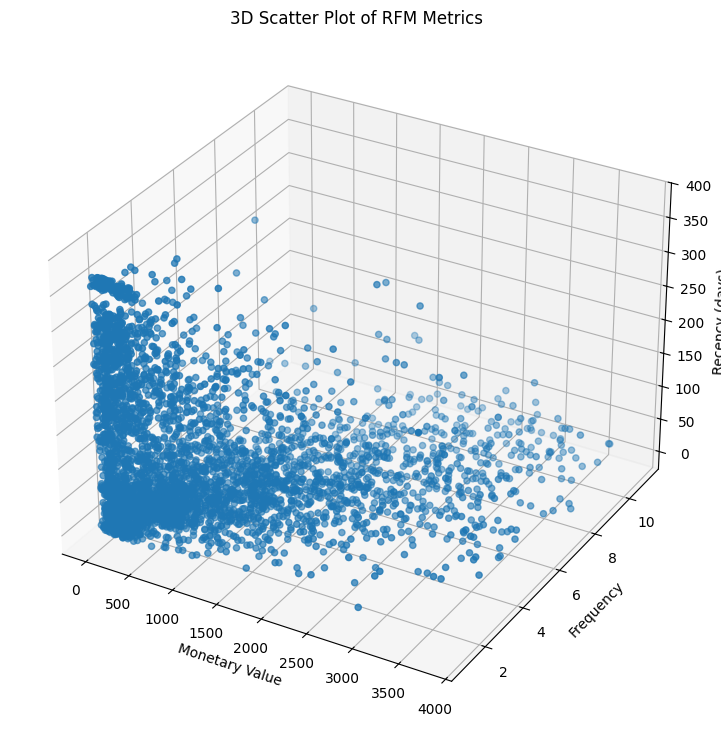

In [33]:
fig = plt.figure(figsize=(9, 9))

ax= fig.add_subplot(projection='3d')

scatter = ax.scatter(
non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency (days)')
plt.title("3D Scatter Plot of RFM Metrics")
plt.show()

In [34]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

scaled_features

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.53551441, -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488782,  0.50659348, -0.81634357]], shape=(3809, 3))

In [35]:
scaled_data_df = pd.DataFrame(scaled_features, columns=["MonetaryValue", "Frequency", "Recency"], index=non_outliers_df.index)
scaled_data_df

,MonetaryValue,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


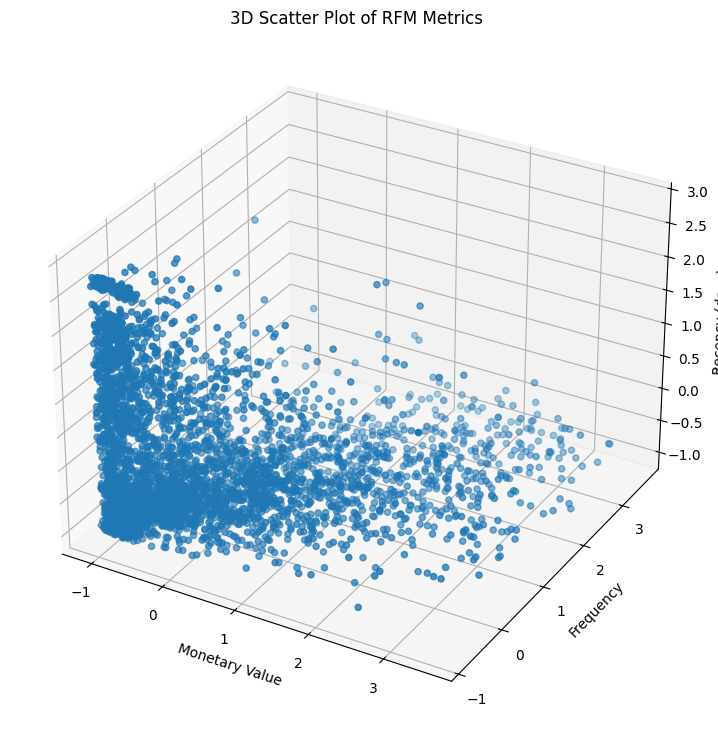

In [36]:
fig = plt.figure(figsize=(9, 9))

ax= fig.add_subplot(projection='3d')

scatter = ax.scatter(
scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency (days)')
plt.title("3D Scatter Plot of RFM Metrics")
plt.show()

## K Means Clustering

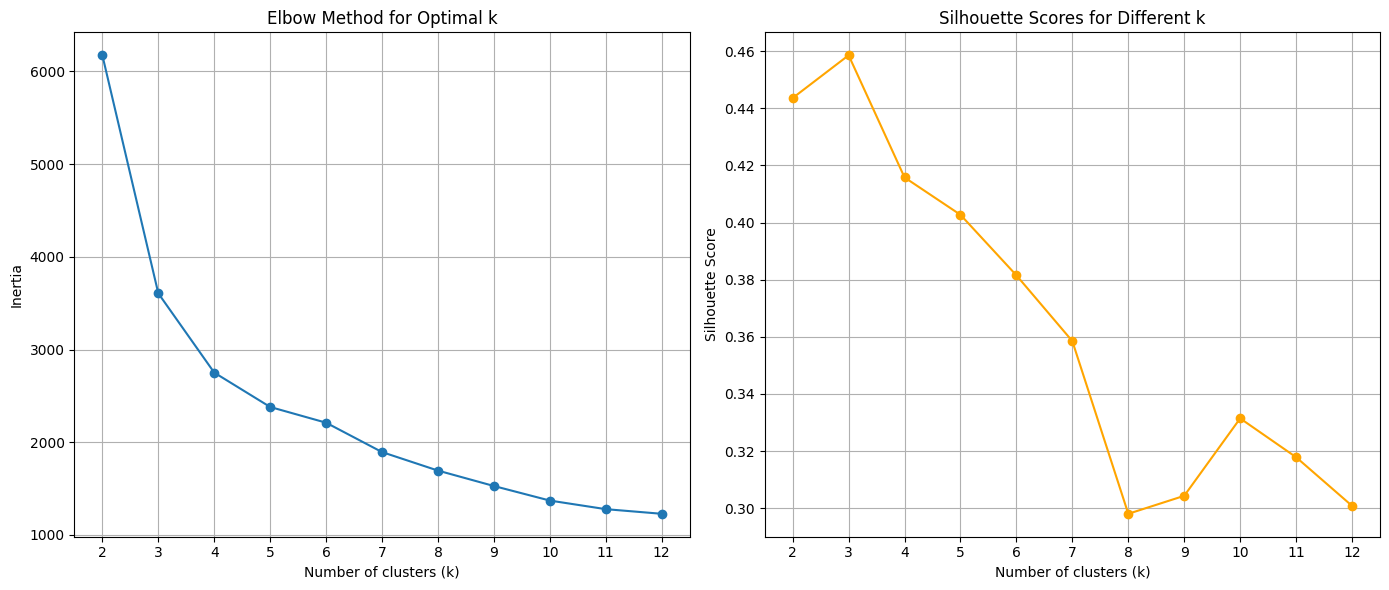

In [37]:
k_max = 12

inertia = []
silhouette_scores = []
k_values = range(2, k_max + 1)

for k in k_values:
    kmeans= KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    silscore = silhouette_score(scaled_data_df, cluster_labels)
    silhouette_scores.append(silscore)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid()
plt.tight_layout()

plt.show()

In [38]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_data_df)
cluster_labels

array([1, 0, 2, ..., 1, 0, 0], shape=(3809,), dtype=int32)

In [39]:
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,0
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,2
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,0


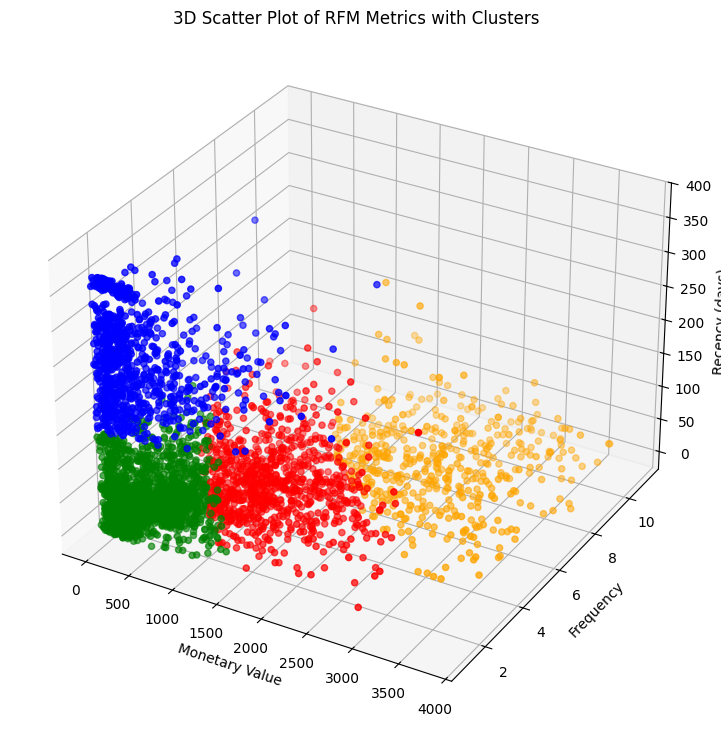

In [40]:
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange'
}

colors = non_outliers_df["Cluster"].map(cluster_colors)

fig = plt.figure(figsize=(9, 9))
ax= fig.add_subplot(projection='3d')

scatter = ax.scatter(
non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"],
c=colors, marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency (days)')
plt.title("3D Scatter Plot of RFM Metrics with Clusters")
plt.show()

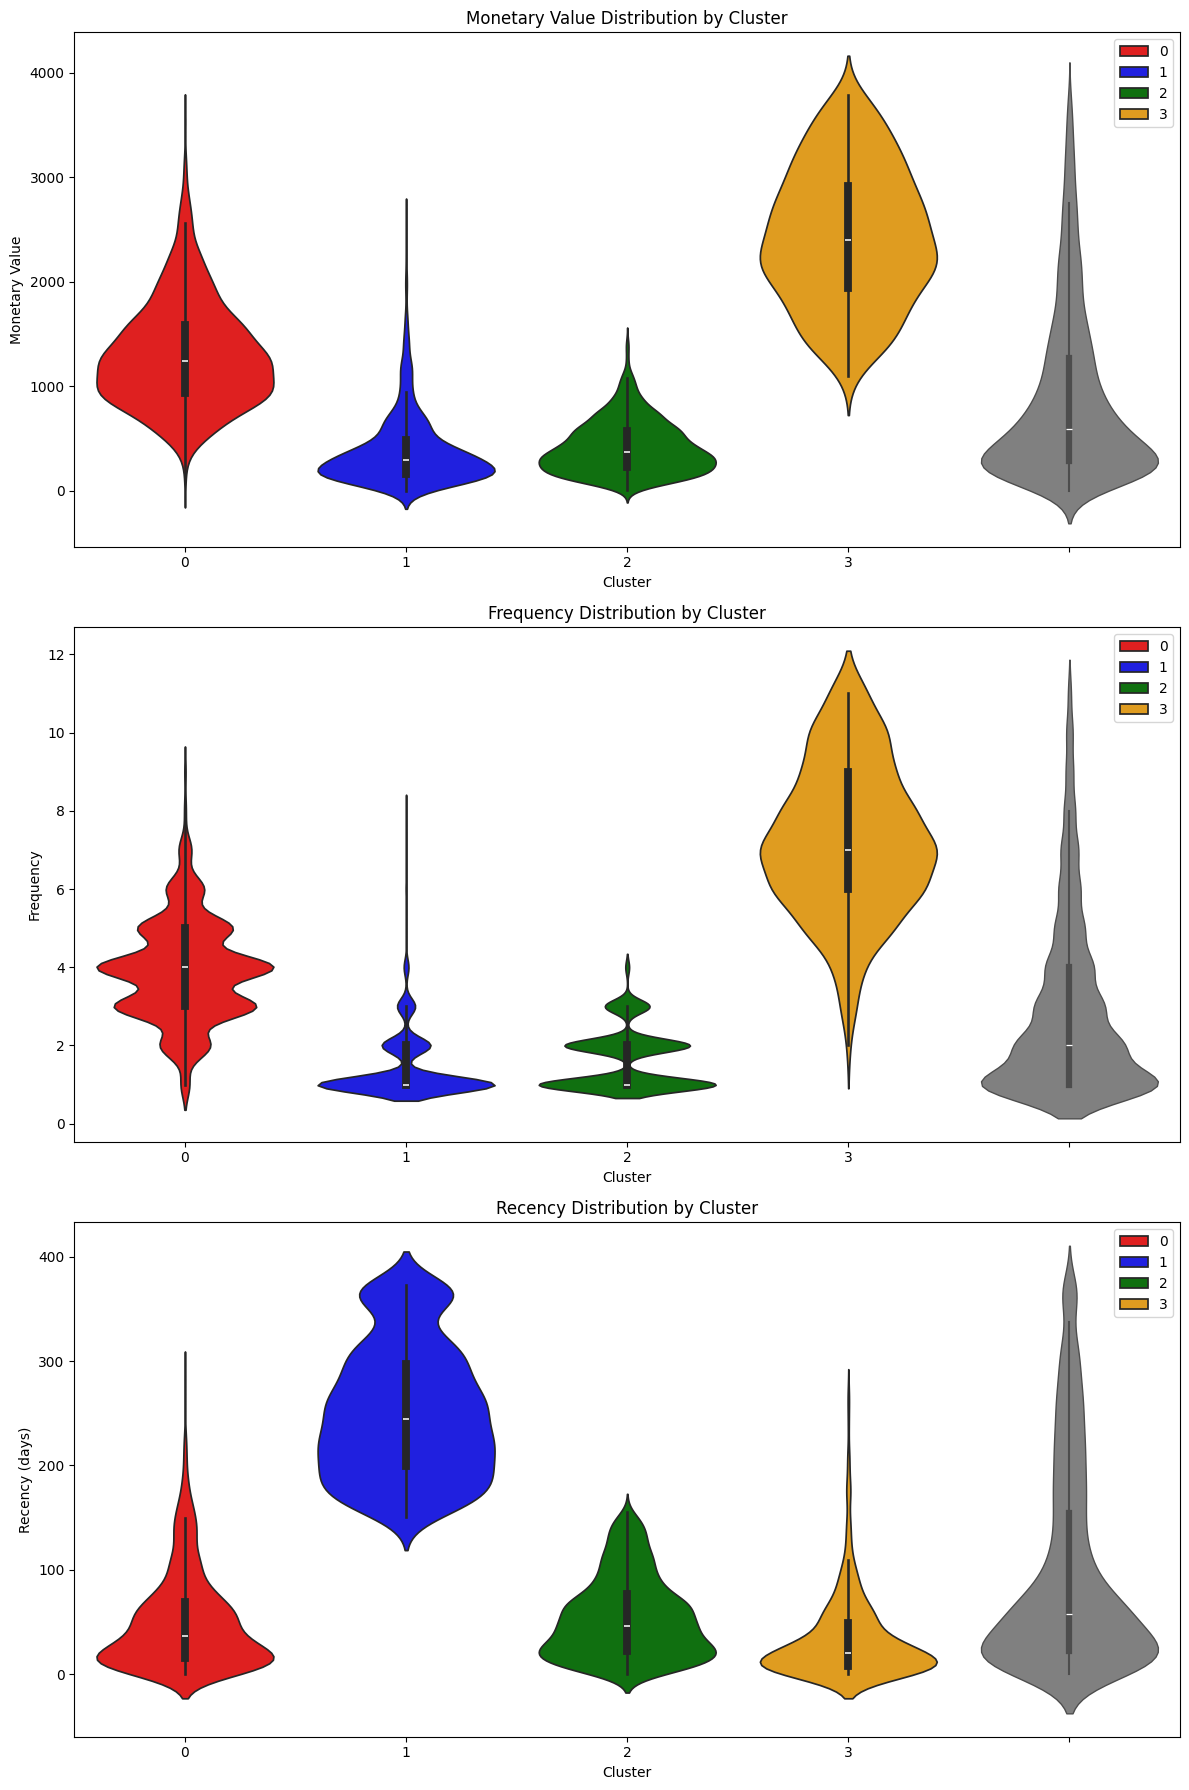

In [41]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["MonetaryValue"], palette=cluster_colors,hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["MonetaryValue"], color='gray',linewidth=1)
plt.title("Monetary Value Distribution by Cluster")
plt.ylabel("Monetary Value")

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["Frequency"], palette=cluster_colors,hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["Frequency"], color='gray',linewidth=1)
plt.title("Frequency Distribution by Cluster")
plt.ylabel("Frequency")

plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df["Cluster"], y=non_outliers_df["Recency"], palette=cluster_colors,hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df["Recency"], color='gray',linewidth=1)
plt.title("Recency Distribution by Cluster")
plt.ylabel("Recency (days)")

plt.tight_layout()
plt.show()

## Cluster Analysis

### Cluster 3 (Orange): "Nurture"
- Rationale: The key differentiator here is Recency. They haven't spent much or often yet, but they interacted with you recently. This suggests they are likely new customers who have just made their first couple of purchases.
- Action: Focus on building relationships, providing excellent customer service, and offering incentives to encourage more frequent purchases.
Implement loyalty programs, personalized offers, and regular engagement to ensure they remain active.

### Cluster 1 (Blue): "Re-Engage"
- Rationale: These customers bought something cheaply once, a long time ago, and haven't returned. They are effectively "churned" or "lost".
- Action: Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again.

### Cluster 2 (Green): "Retain"
- Rationale: These are your most valuable customers. They buy often, spend the most, and are currently active. They love your product or service.
- Action: Implement loyalty programs, personalized offers, and regular engagement to ensure they remain active.

### Cluster 0 (Red): "Reward"
- Rationale: These customers are reliable. They aren't spending quite as much as the Champions, but they are consistent and active. They are likely on their way to becoming Champions.
- Action: Focus on up-selling or cross-selling to increase their monetary value. Engage them to nudge their frequency up slightly.

### Summary of Cluster Names:

- Cluster 0 (Red): "Reward"
- Cluster 1 (Blue): "Re-Engage"
- Cluster 2 (Green): "Retain"
- Cluster 3 (Orange): "Nurture"

In [42]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers_df = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers_df = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers_df = aggregated_df.loc[overlap_indices]

monetary_only_outliers_df["Cluster"] = -1
frequency_only_outliers_df["Cluster"] = -2
monetary_and_frequency_outliers_df["Cluster"] = -3

outlier_clusters_df = pd.concat([
    monetary_only_outliers_df,
    frequency_only_outliers_df,
    monetary_and_frequency_outliers_df
])

outlier_clusters_df


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
9,12357.00,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.00,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.00,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.00,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


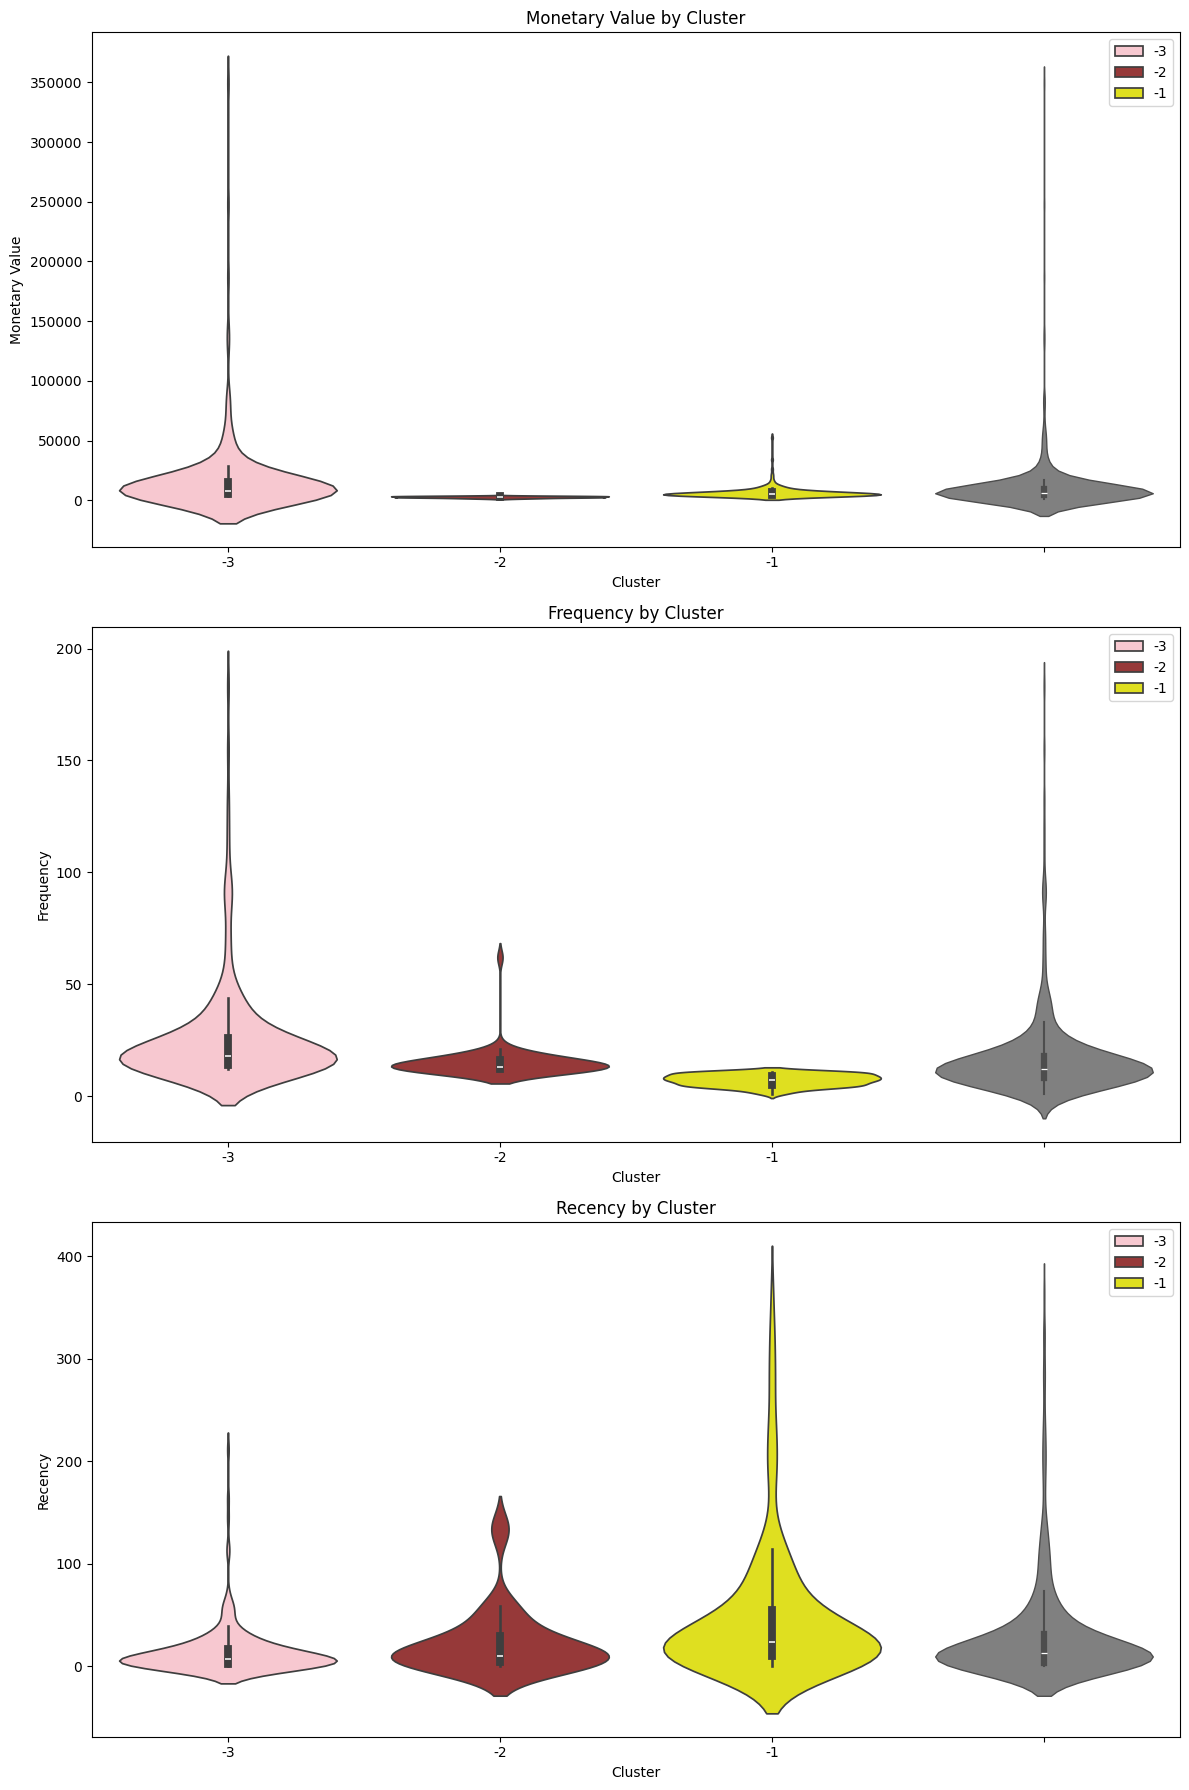

In [43]:
cluster_colors = {-1: 'yellow',
                  -2: 'brown',
                  -3: 'pink'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

## Outlier Analysis
### Cluster -1 (Monetary Outliers) PAMPER:
- Characteristics: High spenders but not necessarily frequent buyers. Their purchases are large but infrequent. Potential Strategy: Focus on maintaining their loyalty with personalized offers or luxury services that cater to their high spending capacity.

### Cluster -2 (Frequency Outliers) UPSELL:
- Characteristics: Frequent buyers who spend less per purchase. These customers are consistently engaged but might benefit from upselling opportunities. Potential Strategy: Implement loyalty programs or bundle deals to encourage higher spending per visit, given their frequent engagement.

### Cluster -3 (Monetary & Frequency Outliers) DELIGHT:
- Characteristics: The most valuable outliers, with extreme spending and frequent purchases. They are likely your top-tier customers who require special attention. Potential Strategy: Develop VIP programs or exclusive offers to maintain their loyalty and encourage continued engagement.

In [44]:
cluster_labels = {
-1: 'PAMPER',
-2: 'UPSELL',
-3: 'DELIGHT',
 0: 'REWARD',
 1: 'RE-ENGAGE',
 2: 'RETAIN',
 3: 'NURTURE'
   }

In [45]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])
full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


In [46]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)
full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0,REWARD
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2,RETAIN
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0,REWARD
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2,RETAIN
...,...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3,DELIGHT


## Visualization

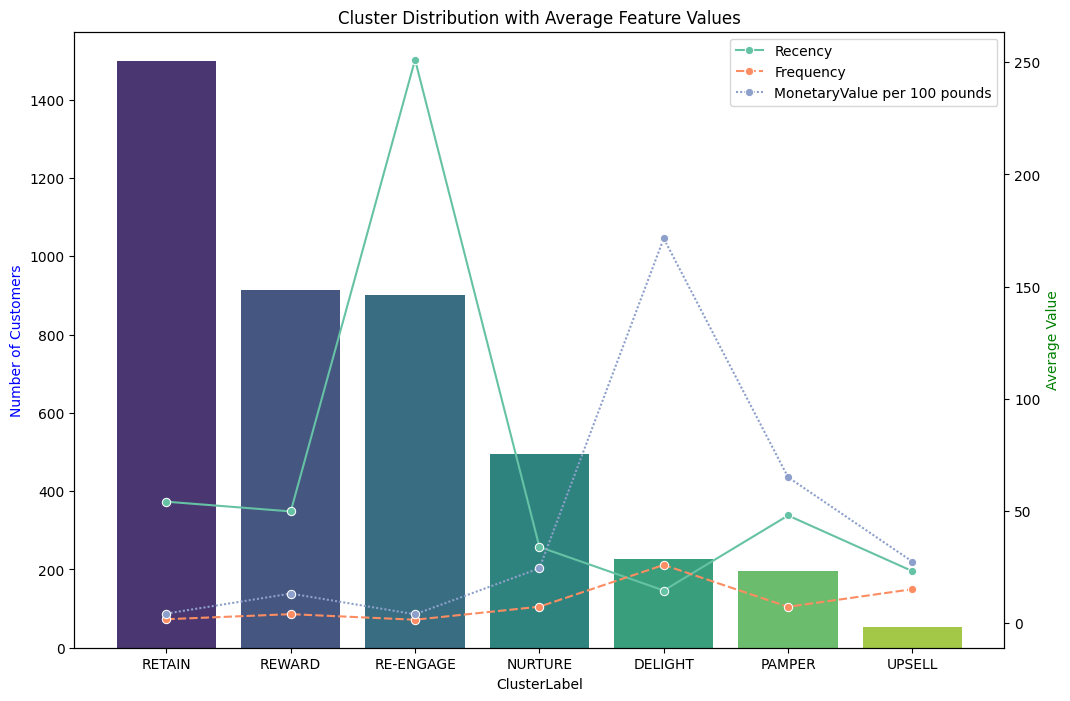

In [47]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

## Executive Summary: Customer Ecosystem Analysis
This project performed a two-tier RFM analysis (Core Clustering + Outlier Detection) on the Online Retail II dataset (2009–2011). The analysis reveals a polarized customer base where revenue is highly concentrated among a small elite percentage, while the majority of the customer volume consists of low-value or inactive users.

### Brief Analysis
1. The "Volume vs. Value" Imbalance The dataset exhibits a steep Pareto distribution. The vast majority of the customer population falls into the Nurture and Re-engage segments (high volume, low value). Conversely, the Delight and Reward segments drive the majority of monetary value despite representing a tiny fraction of the total user count.

2. The "Recency Gap" (Churn Risk) There is a distinct lack of "middle ground" in customer recency.
- Active customers (Reward, Retain, Nurture) typically have a Recency of <100 days.
- Lost customers (Re-engage) have a Recency of >400 days.
- Conclusion: If a customer is not retained within the first 3–6 months, they are statistically likely to drift permanently into the "Lost" segment. The window for re-engagement is short.

3. The "Pamper" Risk Warning The Outlier analysis identified a critical "at-risk" group: the Pamper segment. These are high-spending customers whose recency is creeping up. Unlike the "Delight" whales who remain active, the "Pamper" group represents the single largest revenue risk to the business and requires immediate intervention.

## Strategic Conclusion
- To maximize Customer Lifetime Value (CLV), the marketing strategy must be bifurcated:
For the Masses (Nurture/Retain): Focus on Migration. The goal is to move the massive volume of "Nurture" customers into the "Retain" habit loop through automated onboarding and educational content.
- For the Elite (Delight/Reward): Focus on Protection. These customers do not need marketing; they need relationship management. The priority is to "ring-fence" these users with VIP perks to prevent them from slipping into the "Pamper" or "Re-engage" segments.



In [48]:
full_clustering_df.to_excel("customer_segments.xlsx", index=False)